# Version notes:

Notebook series 06x:
- Updated shopping data thru the end of Aug
- Combine shop analysis with gaps

In [1]:
from functools import reduce
import datetime
from calendar import Calendar
import argparse

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window

In [2]:
# for notebook
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None

In [3]:
# =============================

# VARIABLES & ARGUMENTS
# ----------------
input_dir = "/user/kendra.frederick/shop_vol/encoded/markets/v2"
APP_NAME = "KF-ShopGrid-Jupyter"

In [4]:
# SET UP SPARK
# ----------------
run_mode = "python" 

if run_mode == "python":
    conf1 = pyspark.SparkConf().setAll([
        ("spark.app.name", APP_NAME),
#         ("spark.master","yarn"),
        ("spark.driver.memory","20g"),
#         ("spark.executor.memory", "10g"),
#         ("spark.executor.instances", 5),
#         ("spark.executor.cores", "5"),
        ('spark.sql.crossJoin.enabled', True),
        ('spark.sql.shuffle.partitions', 8) # added this after
        ])
    spark = SparkSession.builder.config(conf = conf1).getOrCreate()
elif run_mode == "spark-submit":
    spark = SparkSession.builder.appName(APP_NAME).getOrCreate()
else:
    pass

In [5]:
spark.sparkContext.applicationId

'local-1662072335250'

# define dates

In [6]:
# assign args to vars
max_days_til_dept = 120 # args.days_til_dept
max_stay_duration = 30 #args.length_of_stay

shop_start_str = "2022-08-01" 
shop_end_str = "2022-08-31" 
# shop_start_str = args.shop_start
# shop_end_str = args.shop_end

# # missing_search_days_str = ["2022-08-15", "2022-08-16", "2022-08-17", "2022-08-18"]
# missing_search_days_str = [] #args.missing_dates or []

search_start = datetime.datetime.strptime(shop_start_str, "%Y-%m-%d").date()
search_end = datetime.datetime.strptime(shop_end_str, "%Y-%m-%d").date()
num_search_days = (search_end - search_start).days + 1

# OUTBOUND DEPARTURE DATES
min_dept_dt = search_start #+ datetime.timedelta(days=1) # filters out same-day searches; include them?
max_dept_dt = search_end + datetime.timedelta(days=max_days_til_dept)
max_return_dt = max_dept_dt + datetime.timedelta(days=max_stay_duration)

# load data

In [7]:
date_enum_path = "/user/kendra.frederick/shop_grid/dates_cross_shop_aug_no_missing"
date_cross_df = spark.read.parquet(date_enum_path)

In [8]:
date_enum_path2 = "/user/kendra.frederick/shop_grid/dates_cross_shop_aug_120dtd"
date_df_missing_removed = spark.read.parquet(date_enum_path2)

In [8]:
date_cross_df.count(), date_df_missing_removed.count()

(108000, 121500)

In [9]:
# load markets to analyze
markets_path = "/user/kendra.frederick/shop_grid/markets.csv"
markets_df = spark.read.csv(markets_path, header=True)
# print("Analyzing {} markets".format(markets_df.count()))

temp = markets_df.select("market_key_decoded").collect()
market_list = [x["market_key_decoded"] for x in temp]

markets_df = markets_df.withColumnRenamed("market_key_decoded", "market")

In [10]:
df = spark.read.parquet(input_dir)

Confirm updated search dates

In [10]:
df.select(F.min('searchDt'), F.max('searchDt')).show()

+-------------+-------------+
|min(searchDt)|max(searchDt)|
+-------------+-------------+
|     20220801|     20220831|
+-------------+-------------+



In [11]:
df = df.withColumn("market", 
    F.concat_ws("-", F.col("origin_decoded"), F.col("dest_decoded")))

# In a perfect world, shouldn't need to do this; input data is derived from markets.
# However, this list has been changed, so join vs. current list 
# to "clean up" input data
df_join = df.join(F.broadcast(markets_df), on="market", how="inner")

# convert Dept dates (which are strings) to datetime
df_join.registerTempTable("data")
df_join = spark.sql("""
    SELECT *,
        TO_DATE(CAST(UNIX_TIMESTAMP(CAST(outDeptDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS outDeptDt_dt,
        TO_DATE(CAST(UNIX_TIMESTAMP(CAST(inDeptDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS inDeptDt_dt,
        TO_DATE(CAST(UNIX_TIMESTAMP(CAST(searchDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS searchDt_dt
    FROM data
""")

# filter on dates & round-trip
df_filt = (df_join
            .filter(F.col("outDeptDt_dt").between(min_dept_dt, max_dept_dt))
            # Note: when we filter on stay duration below, this also
            # effectively accomplishes filtering on round-trip == 1
            .filter(F.col("round_trip") == 1)
        )

# group by market + travel dates + search date and count shops
cnt_df = (df_join
            .groupBy(["market", 
                        "searchDt_dt", "outDeptDt_dt", "inDeptDt_dt", # "round_trip"
                        ])
            .agg(
                F.sum("solution_counts").alias("sum_solution_counts"),
                F.sum("shop_counts").alias("sum_shop_counts")
            )
            .withColumn("shop_ind", F.lit(1)) # add an indicator column
            )

cnt_df = cnt_df.withColumn('stay_duration',
                F.datediff(
                    F.col('inDeptDt_dt'), F.col('outDeptDt_dt'))
                )

# Note this effectively filters out null stay durations, which are one-way trips
cnt_df = cnt_df.filter(F.col('stay_duration').between(0, max_stay_duration))

cnt_df.repartition("market")

DataFrame[market: string, searchDt_dt: date, outDeptDt_dt: date, inDeptDt_dt: date, sum_solution_counts: bigint, sum_shop_counts: bigint, shop_ind: int, stay_duration: int]

In [11]:
# cnt_df.show(5)

+-------+-----------+------------+-----------+-------------------+---------------+--------+-------------+
| market|searchDt_dt|outDeptDt_dt|inDeptDt_dt|sum_solution_counts|sum_shop_counts|shop_ind|stay_duration|
+-------+-----------+------------+-----------+-------------------+---------------+--------+-------------+
|LHR-IST| 2022-08-20|  2022-09-04| 2022-09-11|             108726|           1079|       1|            7|
|BKK-ICN| 2022-08-20|  2022-09-21| 2022-10-01|              39496|            201|       1|           10|
|SIN-BKK| 2022-08-20|  2022-12-01| 2022-12-04|             123148|            501|       1|            3|
|LHR-BKK| 2022-08-20|  2022-11-15| 2022-12-03|               1768|             30|       1|           18|
|LHR-JFK| 2022-08-20|  2022-08-24| 2022-08-27|             162850|            412|       1|            3|
+-------+-----------+------------+-----------+-------------------+---------------+--------+-------------+
only showing top 5 rows



In [12]:
# cnt_df.count()

# define funcs

In [17]:

def process_base(market, input_df, date_enum_df):
    mrkt_df = input_df.filter(F.col("market") == market)

    join_cols = ['outDeptDt_dt', 'stay_duration', 'searchDt_dt']

    # join with enum date df
    mrkt_join_df = (mrkt_df.join(date_enum_df, 
                                on=join_cols, 
                                how='outer')
                        .fillna(0, subset=['sum_solution_counts', 'sum_shop_counts', 'shop_ind'])
                )

    # calculate `days_til_dept`
    mrkt_join_df = mrkt_join_df.withColumn('days_til_dept',
                    F.datediff(
                        F.col('outDeptDt_dt'), F.col('searchDt_dt'))
                    )

    # And then filter on it
    mrkt_join_df = mrkt_join_df.filter(F.col('days_til_dept').between(0, max_days_til_dept))

    return mrkt_join_df


In [12]:
def window_calcs_shops(market, mrkt_join_df, window_size=3):

    # WINDOW CALCS
    # - must do window calc's after cross-join with enum date df
    #   so the 0's are included in window calcs
    # - want to use rows rather than range here, since we are excluding missing search days
    #   (otherwise, rows vs. range approach *should* be equivalent)
    
    # Note: if using rangeBetween, must convert date to long (via ts) 
    # mrkt_join_df.createOrReplaceTempView("mdf")
    # mrkt_join_df = spark.sql("""
    #     SELECT *,
    #         CAST(searchDt_dt as TIMESTAMP) AS searchDt_ts
    #     FROM mdf
    # """)
    # mrkt_join_df = mrkt_join_df.withColumn("searchDt_long", F.col("searchDt_ts").cast('long'))


    window = (Window.partitionBy('outDeptDt_dt', 'stay_duration')
    #                 .orderBy('searchDt_long')
    #                 .rangeBetween(-sec_in_day(window_size-1), 0)
                    .orderBy('searchDt_dt')
                    .rowsBetween(-(window_size-1), Window.currentRow)
            )

    market_window_df = (mrkt_join_df
            .withColumn("sum_solutions_window", F.sum("sum_solution_counts").over(window))
            .withColumn("num_shop_days_window", F.sum("shop_ind").over(window))
            .withColumn("avg_solutions_window", F.mean("sum_solution_counts").over(window))
            .withColumn("avg_shop_days", F.mean("shop_ind").over(window))
            )

    # add this for filtering out the first rows in a window, which don't have complete aggregates
    # Note: can't have restriction on rowsBetween for row_number calc
    # so must do as a separate window calc
    window2 = (Window.partitionBy('outDeptDt_dt', 'stay_duration')
                    .orderBy('searchDt_dt')
            )

    market_window_df2 = (market_window_df
                .withColumn("grp_num", F.row_number().over(window2))         
            )

    market_window_df2 = market_window_df2.filter(F.col("grp_num") >= window_size)

    # send to Pandas for plotting
    market_pdf = market_window_df2.toPandas()

    return market_pdf


from itertools import groupby

def _inspect_gaps(arr, gap_val=0):
    """
    return:
    array of [max gap size, num gaps, avg gap size]
    """
    grp_arr = [(k, sum(1 for _ in num)) for k, num in groupby(arr)]
    gap_tuples = [v for k,v in grp_arr if k == gap_val]
    if len(gap_tuples) == 0:
        return 0.0, 0.0, 0.0
    else:
        return float(max(gap_tuples)), float(len(gap_tuples)), float(np.mean(gap_tuples))

# inspect_gaps = F.udf(_inspect_gaps, T.ArrayType(T.IntegerType()))
inspect_gaps = F.udf(_inspect_gaps, T.ArrayType(T.FloatType()))



def window_calcs_gaps(market, mrkt_join_df):

        w = (Window.partitionBy('outDeptDt_dt', 'stay_duration')
                        .orderBy('searchDt_dt')
                        .rowsBetween(Window.unboundedPreceding, Window.currentRow)
                )

        win_df = (mrkt_join_df
                .withColumn("values", F.collect_list("shop_ind").over(w))
                .withColumn("num_days_w_shop", F.sum("shop_ind").over(w))
                )

        win_df = (win_df
                .withColumn("num_shop_days", F.size(F.col("values")))
                .withColumn("num_days_wo_shop", F.col("num_shop_days") - F.col("num_days_w_shop"))
                .withColumn("gap_analysis", inspect_gaps(F.col("values")))
                .withColumn("num_gaps", F.col("gap_analysis").getItem(1))
                .withColumn("max_gap_size", F.col("gap_analysis").getItem(0))
                .withColumn("avg_gap_size", F.col("gap_analysis").getItem(2))
                .withColumn("norm_max_gap_size", F.col("max_gap_size")/F.col("num_shop_days"))
                .withColumn("norm_num_gaps", F.col("num_gaps")/F.col("num_shop_days"))
                )

        # add group number, for filtering
        w2 = (Window
        .partitionBy("outDeptDt_dt", "stay_duration")
        .orderBy(F.desc("searchDt_dt"))
        )
        win_df_filt = (win_df
                .withColumn("grp_num", F.row_number().over(w2))
                .filter(F.col("grp_num") == 1)
                )
        mrkt_pdf = win_df_filt.toPandas()
        return mrkt_pdf

In [29]:
def plot_gaps_by_days_til_dept(market, mrkt_pdf, save_fig=True):
    file_name = "_".join([market, "gaps", "by-days-til-dept"])

    agg_dict = {"max_gap_size": "max",
                "avg_gap_size": "mean",
                "num_gaps": "mean",
                "num_days_wo_shop": "sum",
                "shop_ind": ["sum", "mean"]
                }
    agg_cols = ["max_gap_size", 
                "avg_gap_size",
                "avg_num_gaps",
                "total_num_days_wo_shop",
                "total_num_days_w_shop", "pct_days_w_shop",
            ] 

    agg_dtd = (mrkt_pdf
                    .groupby(["days_til_dept", "stay_duration"])
                    .agg(agg_dict)
                )

    agg_dtd.columns = agg_cols
    agg_dtd = agg_dtd.reset_index()

    dtd_pvt2 = agg_dtd.pivot(index="stay_duration", 
                    columns="days_til_dept", 
                    values="max_gap_size")

    dtd_pvt3 = agg_dtd.pivot(index="stay_duration", 
                        columns="days_til_dept", 
                        values="avg_gap_size")

    dtd_pvt4 = agg_dtd.pivot(index="stay_duration", 
                        columns="days_til_dept", 
                        values="avg_num_gaps")

    n = 3
    i = 1
    x_label = "days until departure"
    fig1, _ = plt.subplots(n,1, figsize=(12, 10))#(max_days_til_dept//5, (max_stay_duration//6)*2))
        
    with sns.axes_style("white"):
        plt.subplot(n,1,i)
        sns.heatmap(dtd_pvt4, cmap='Greens', square=True,
                    vmin=0,
                    cbar_kws={'shrink': 0.5,
                        'label': 'days',
                            });
        plt.title("Average number gaps");
        plt.ylabel("stay duration (days)")
        plt.xlabel(x_label);
    i += 1

    with sns.axes_style("white"):
        plt.subplot(n,1,i)
        sns.heatmap(dtd_pvt2, cmap='Greens', square=True,
                    vmin=0,
                    cbar_kws={'shrink': 0.5,
                        'label': 'days',
                            });
        plt.title("Max gap size (days)");
        plt.ylabel("stay duration (days)")
        plt.xlabel(x_label);

    i += 1
    with sns.axes_style("white"):
        plt.subplot(n,1,i)
        sns.heatmap(dtd_pvt3, cmap='Greens', square=True,
                    vmin=0,
                    cbar_kws={'shrink': 0.5,
                        'label': 'days',
                            });
        plt.title("Avg gap size (days)");
        plt.ylabel("stay duration (days)")
        plt.xlabel(x_label);

    fig1.suptitle(market)
    fig1.tight_layout()
    plt.subplots_adjust(top=0.94, hspace=0.25)
    fig1.show()
    if save_fig:
        plt.savefig(out_dir + file_name + ".png", format="png")

In [30]:
def plot_gaps_by_dept_dt(market, mrkt_pdf, save_fig=False):
    file_name = "_".join([market, "gaps", "by-dept-date"])
#     date_pvt1 = mrkt_pdf.pivot(index="stay_duration", 
#                         columns="outDeptDt_dt", 
#                         values="norm_num_gaps")

    date_pvt2 = mrkt_pdf.pivot(index="stay_duration", 
                        columns="outDeptDt_dt", 
                        values="max_gap_size")

    date_pvt3 = mrkt_pdf.pivot(index="stay_duration", 
                        columns="outDeptDt_dt", 
                        values="avg_gap_size")

    date_pvt4 = mrkt_pdf.pivot(index="stay_duration", 
                    columns="outDeptDt_dt", 
                    values="num_gaps")
    
    n = 3
    i = 1
    fig1, _ = plt.subplots(n,1, figsize=(12,10))#(max_days_til_dept//5, (max_stay_duration//6)*2))

    with sns.axes_style("white"):
        plt.subplot(n,1,i)
        sns.heatmap(date_pvt4, cmap='Greens', square=True,
                    vmin=0,
                    cbar_kws={'shrink': 0.5,
                        'label': 'days',
                    });
        plt.title("Number gaps");
        plt.ylabel("stay duration (days)")
        plt.xlabel("departure date");
        
    i += 1
    with sns.axes_style("white"):
        plt.subplot(n,1,i)
        sns.heatmap(date_pvt2, cmap='Greens', square=True,
                    vmin=0,
                    cbar_kws={'shrink': 0.5,
                        'label': 'days',
                    });
        plt.title("Max gap size (days)");
        plt.ylabel("stay duration (days)")
        plt.xlabel("departure date");
    
    i += 1
    with sns.axes_style("white"):
        plt.subplot(n,1,i)
        sns.heatmap(date_pvt3, cmap='Greens', square=True,
                    vmin=0,
                    cbar_kws={'shrink': 0.5,
                        'label': 'days',
                        });
        plt.title("Avg gap size (days)");
        plt.ylabel("stay duration (days)")
        plt.xlabel("departure date");

    fig1.suptitle(market)
    fig1.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.5)
    fig1.show()
    if save_fig:
        plt.savefig(out_dir + file_name + ".png", format="png")

In [22]:

def plot_shops(market, market_pdf, what_to_plot="shops", save_fig=False):
    """
    params:
    --------
    what_to_plot (str): ["shops", "vol", "both"]
    """
    # AGGREGATE DATA
    agg_cols = ["num_shop_days", "avg_pct_coverage_shop", 
                "total_num_solutions", "avg_num_solutions"] 
    agg_dict = {"shop_ind": "sum", 
                "avg_shop_days": "mean",
                "sum_solution_counts": ["sum", "mean"]
                        }

    agg_dtd = (market_pdf
                    .groupby(["days_til_dept", "stay_duration"])
                    .agg(agg_dict)
                )
    agg_dtd.columns = agg_cols
    agg_dtd = agg_dtd.reset_index()

    agg_dept_dt = (market_pdf
                    .groupby(["outDeptDt_dt", "stay_duration"])
                    .agg(agg_dict)
                )
    agg_dept_dt.columns = agg_cols
    agg_dept_dt = agg_dept_dt.reset_index()


    # PIVOT & PLOT
    file_name = "_".join([market, "shops"])

    
    # number of shop days -- a boolean
    if what_to_plot in ["shops", "both"]:
        file_name += "_bool"

        pvt1 = agg_dept_dt.pivot(index="stay_duration", 
                                columns="outDeptDt_dt", 
                                values="num_shop_days")

        pvt2 = agg_dept_dt.pivot(index="stay_duration", 
                            columns="outDeptDt_dt", 
                            values="avg_pct_coverage_shop")

        pvt3 = agg_dtd.pivot(index="stay_duration", 
                            columns="days_til_dept", 
                            values="num_shop_days")
        

#         pvt4 = agg_dtd.pivot(index="stay_duration", 
#                             columns="days_til_dept", 
#                             values="avg_pct_coverage_shop")

        n=3
        i=1
#         fig1, _ = plt.subplots(n,1, figsize=(max_days_til_dept//5, (max_stay_duration//(n*3)*2)))
        fig1, _ = plt.subplots(n,1, figsize=(15, 12))
        
        with sns.axes_style("white"):
            plt.subplot(n,1,i)
            sns.heatmap(pvt1, cmap='Greens', square=True,
                        vmin=0,
                        cbar_kws={'label': 'number days w/ a shop',
                                'shrink': 0.5});
            plt.title("Total num shop days");
            plt.ylabel("stay duration (days)")
            plt.xlabel("departure date");
        
        i+=1
        with sns.axes_style("white"):
            plt.subplot(n,1,i)
            sns.heatmap(pvt2, cmap='Greens', square=True,
                        vmin=0, vmax=1.0,
                        cbar_kws={'label': 'avg % coverage',
                                'shrink': 0.5});
            plt.title("Average % Coverage - rolling 3-day window of shopping");
            plt.ylabel("stay duration (days)")
            plt.xlabel("departure date");

        i+=1
        with sns.axes_style("white"):
            plt.subplot(n,1,i)
            sns.heatmap(pvt3, cmap='Greens', square=True,
                        vmin=0,
                        cbar_kws={'label': 'num shop days',
                                'shrink': 0.5});
            plt.title("Num shop days");
            plt.ylabel("stay duration (days)")
            plt.xlabel("days until departure");
                               
        fig1.suptitle(market)
        fig1.tight_layout()
        plt.subplots_adjust(top=0.93, hspace=0.5)
        fig1.show()

        if save_fig:
#             plt.savefig(out_dir + file_name + "_by-dept-date.png", format="png")
            plt.savefig(out_dir + file_name + ".png", format="png")
        

In [20]:
# where to save figures -- make sure it ends in a '/'
out_dir = "./output/06/travel-120-days_shop-2022-08-01_2022-08-31_v2/"

In [ ]:
market = 'JFK-LHR'
shops_proc_df = process_base(market, cnt_df, date_df_missing_removed)
shops_pdf = window_calcs_shops(market, shops_proc_df)

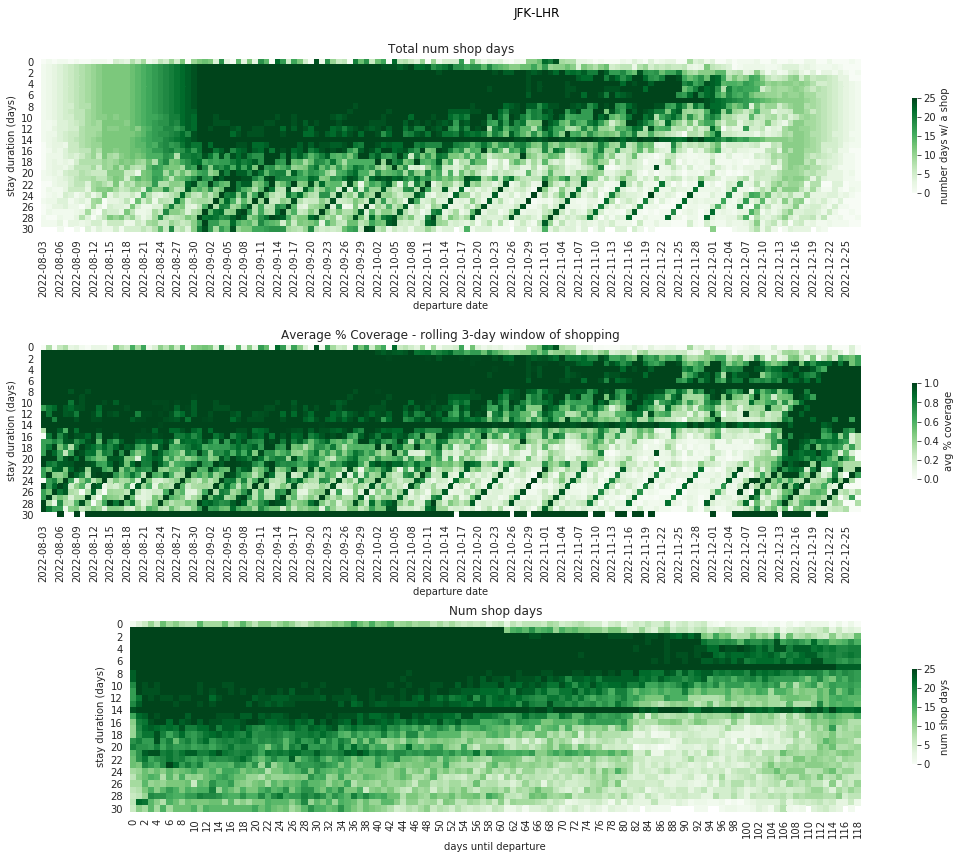

In [23]:
plot_shops(market, shops_pdf, "shops", True)

In [ ]:
gaps_proc_df = process_base(market, cnt_df, date_cross_df)
gaps_pdf = window_calcs_gaps(market, gaps_proc_df)

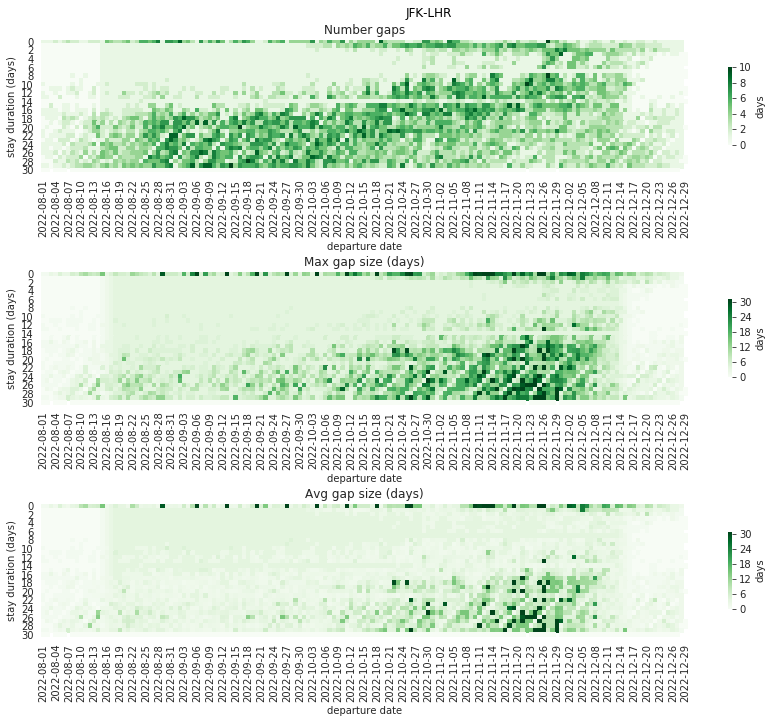

In [31]:
plot_gaps_by_dept_dt(market, gaps_pdf, True)

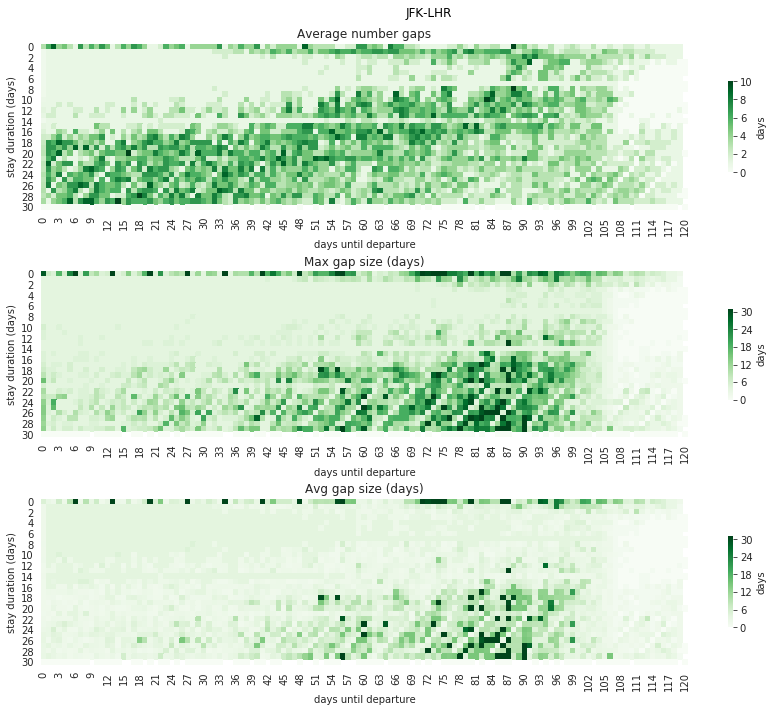

In [32]:
plot_gaps_by_days_til_dept(market, gaps_pdf, True)

# other markets

In [33]:
markets_to_plot = [
    'LHR-JFK',
    'DFW-ORD',
    'JFK-LAX',
    'BKK-SIN',
    'DEL-BOM',
    'SYD-MEL',
    'LHR-BKK',
    'LHR-DOH',
]

In [ ]:
market_list

In [35]:
for market in markets_to_plot:
    print(f"Processing {market}")
    shops_proc_df = process_base(market, cnt_df, date_df_missing_removed)
    shops_pdf = window_calcs_shops(market, shops_proc_df)
    plot_shops(market, shops_pdf, "shops", True)
    plt.close()
    gaps_proc_df = process_base(market, cnt_df, date_cross_df)
    gaps_pdf = window_calcs_gaps(market, gaps_proc_df)
    plot_gaps_by_days_til_dept(market, gaps_pdf, True)
    plt.close()
    plot_gaps_by_dept_dt(market, gaps_pdf, True)
    plt.close()

Processing LHR-JFK
Processing DFW-ORD
Processing JFK-LAX
Processing BKK-SIN
Processing DEL-BOM
Processing SYD-MEL
Processing LHR-BKK
Processing LHR-DOH


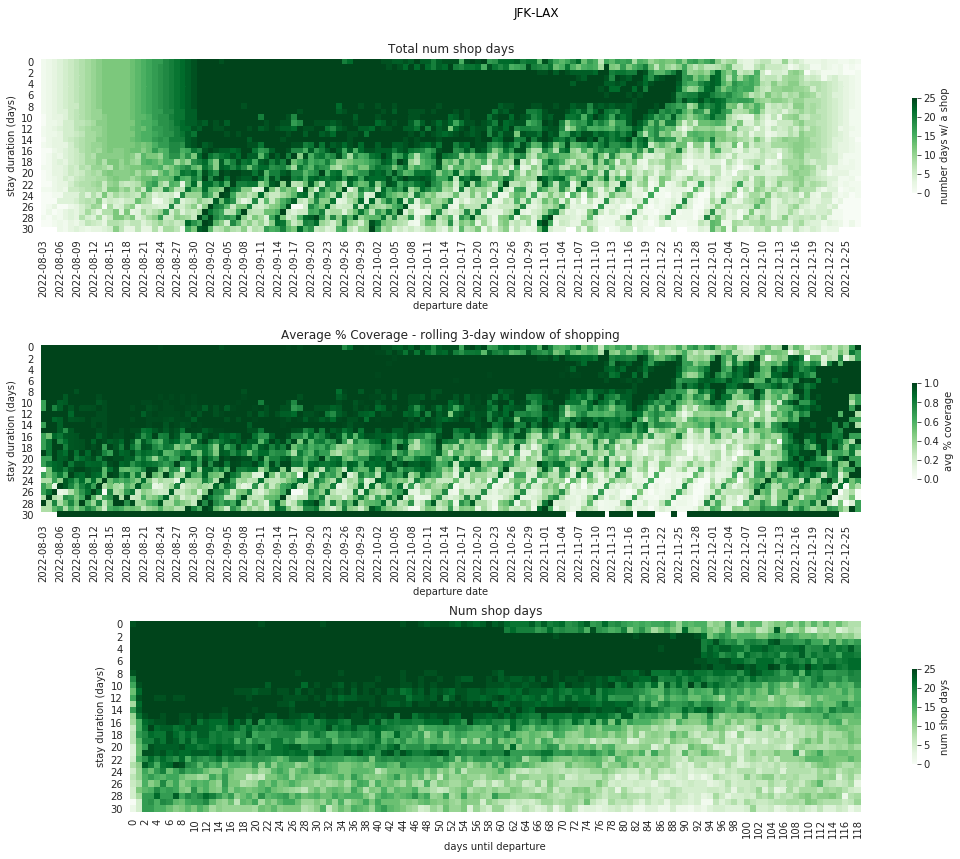

In [36]:
market = 'JFK-LAX'
shops_proc_df = process_base(market, cnt_df, date_df_missing_removed)
shops_pdf = window_calcs_shops(market, shops_proc_df)
plot_shops(market, shops_pdf, "shops", True)

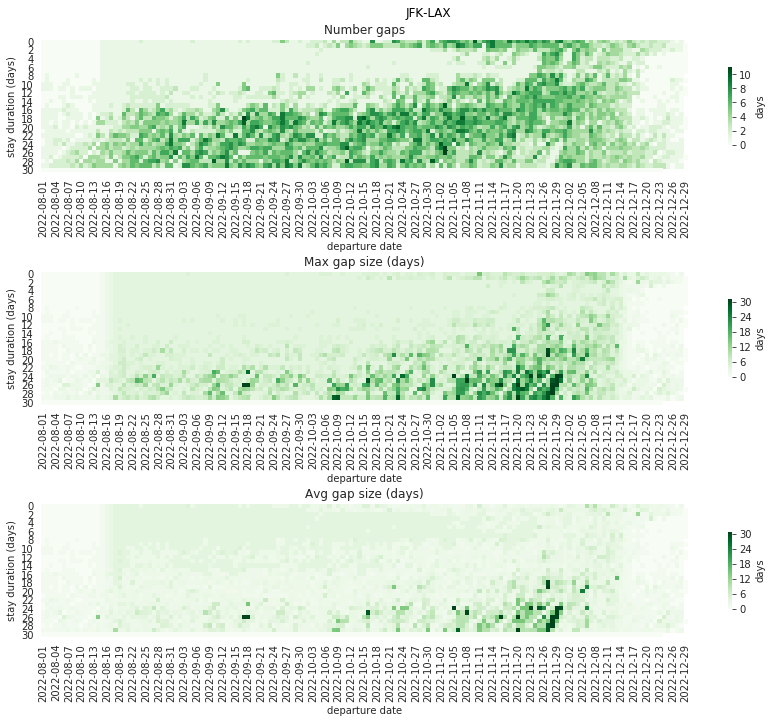

In [37]:
gaps_proc_df = process_base(market, cnt_df, date_cross_df)
gaps_pdf = window_calcs_gaps(market, gaps_proc_df)
# plot_gaps_by_days_til_dept(market, gaps_pdf, True)
plot_gaps_by_dept_dt(market, gaps_pdf, True)

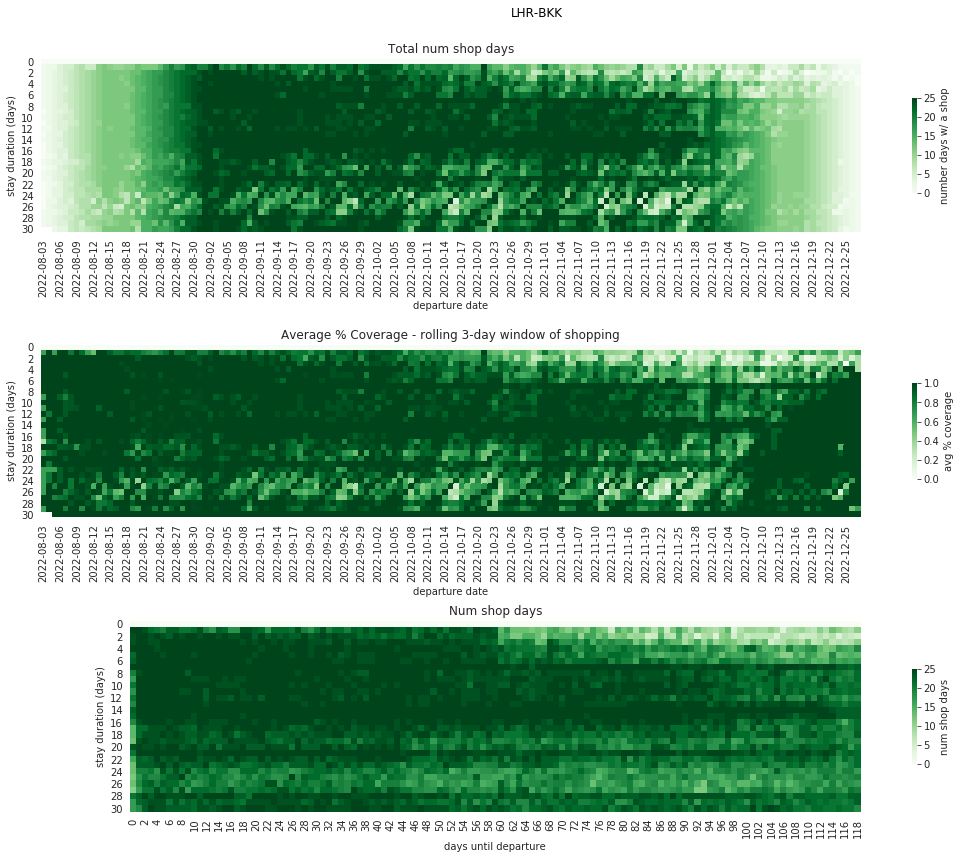

In [38]:
market = 'LHR-BKK'
shops_proc_df = process_base(market, cnt_df, date_df_missing_removed)
shops_pdf = window_calcs_shops(market, shops_proc_df)
plot_shops(market, shops_pdf, "shops", False)

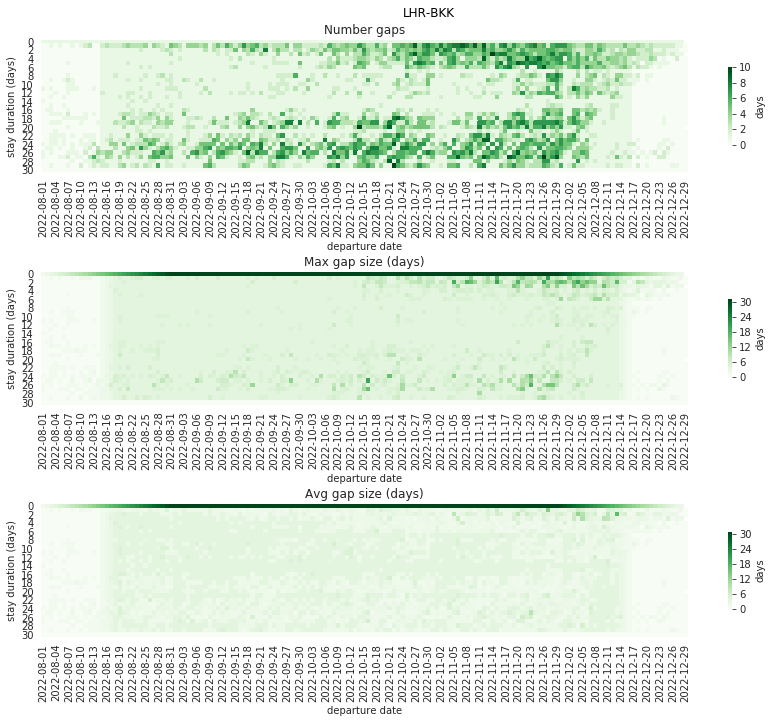

In [39]:
gaps_proc_df = process_base(market, cnt_df, date_cross_df)
gaps_pdf = window_calcs_gaps(market, gaps_proc_df)
# plot_gaps_by_days_til_dept(market, gaps_pdf, True)
plot_gaps_by_dept_dt(market, gaps_pdf, False)

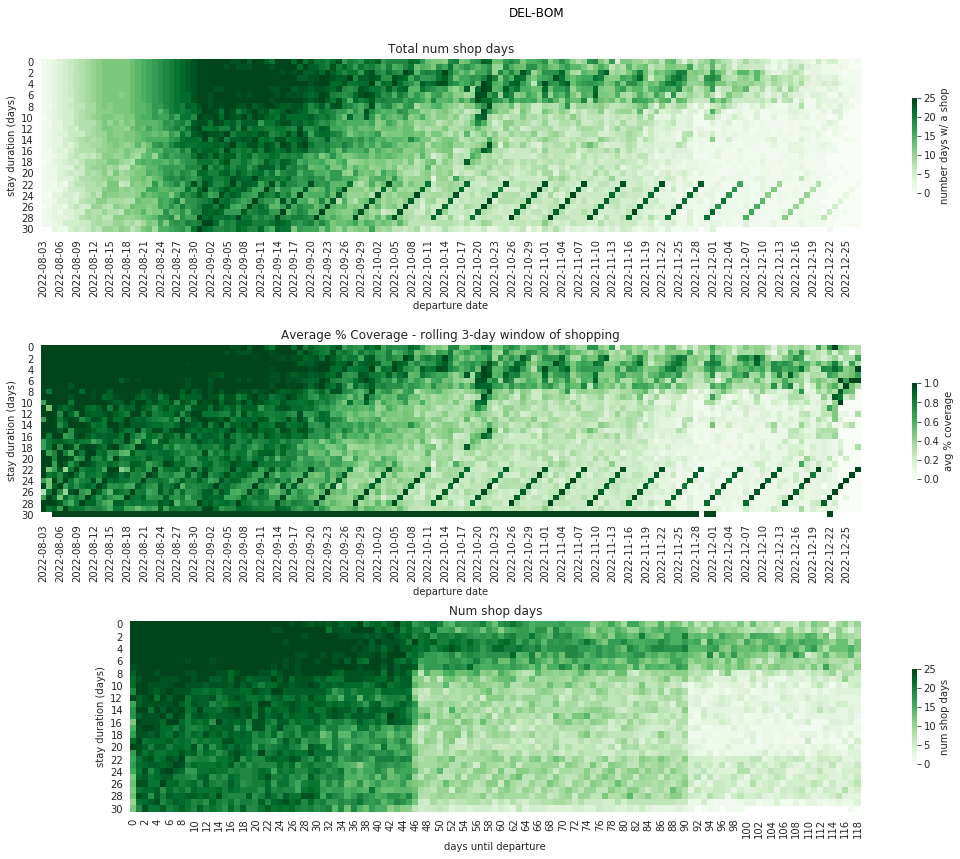

In [40]:
market = 'DEL-BOM'
shops_proc_df = process_base(market, cnt_df, date_df_missing_removed)
shops_pdf = window_calcs_shops(market, shops_proc_df)
plot_shops(market, shops_pdf, "shops", False)

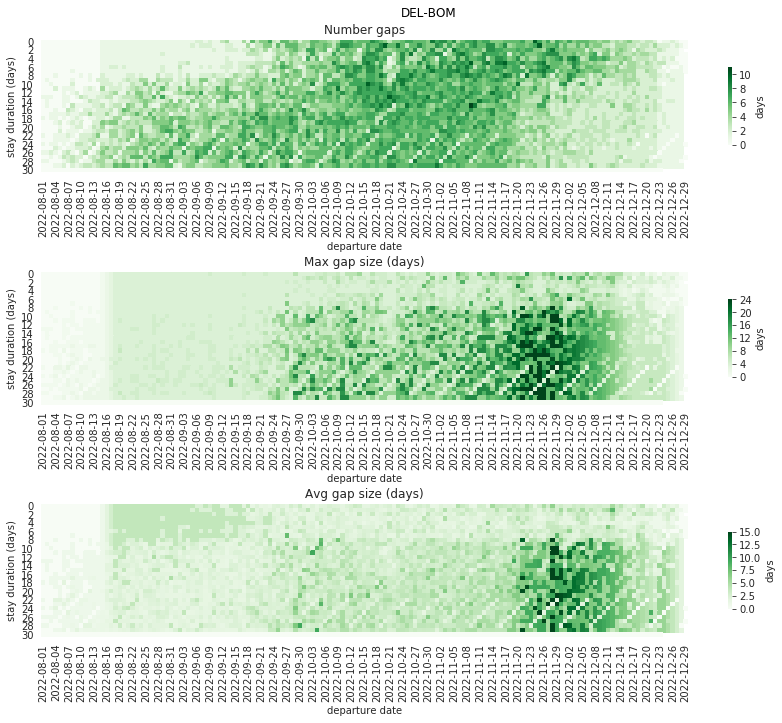

In [41]:
gaps_proc_df = process_base(market, cnt_df, date_cross_df)
gaps_pdf = window_calcs_gaps(market, gaps_proc_df)
# plot_gaps_by_days_til_dept(market, gaps_pdf, True)
plot_gaps_by_dept_dt(market, gaps_pdf, False)

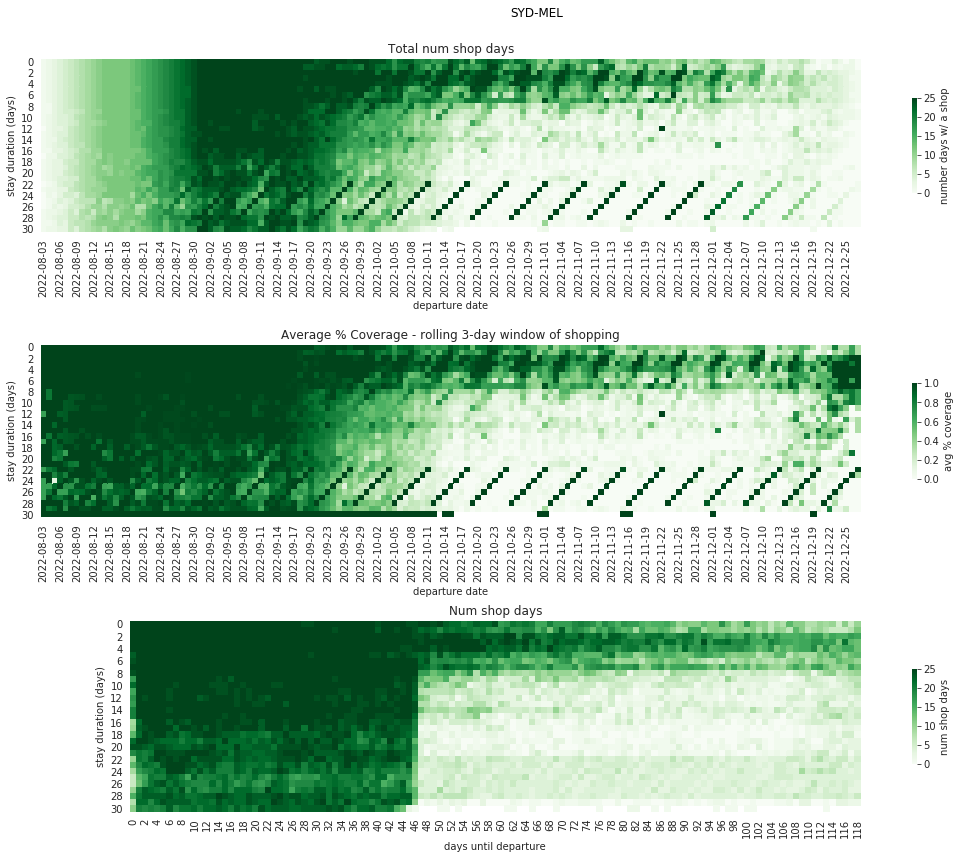

In [42]:
market = 'SYD-MEL'
shops_proc_df = process_base(market, cnt_df, date_df_missing_removed)
shops_pdf = window_calcs_shops(market, shops_proc_df)
plot_shops(market, shops_pdf, "shops", False)

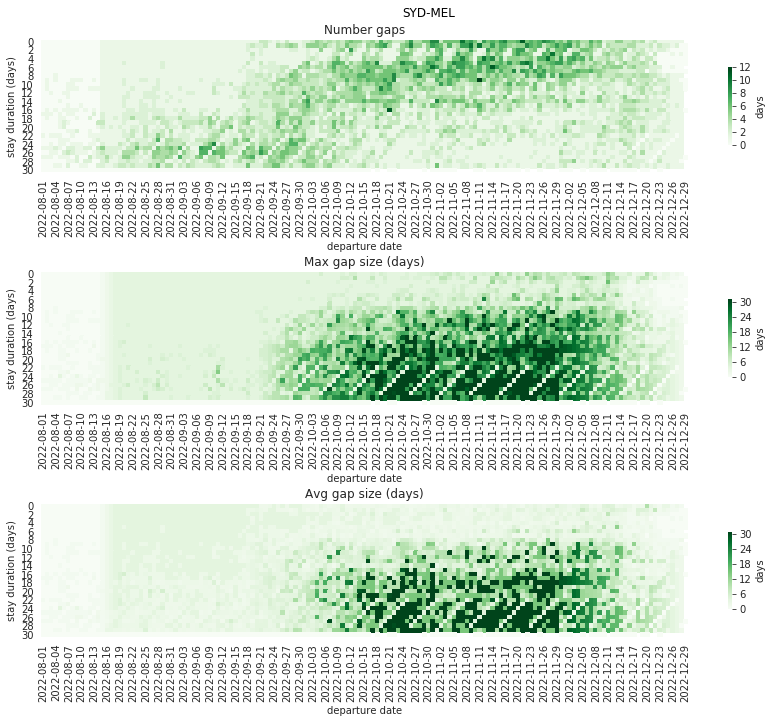

In [43]:
gaps_proc_df = process_base(market, cnt_df, date_cross_df)
gaps_pdf = window_calcs_gaps(market, gaps_proc_df)
# plot_gaps_by_days_til_dept(market, gaps_pdf, True)
plot_gaps_by_dept_dt(market, gaps_pdf, False)

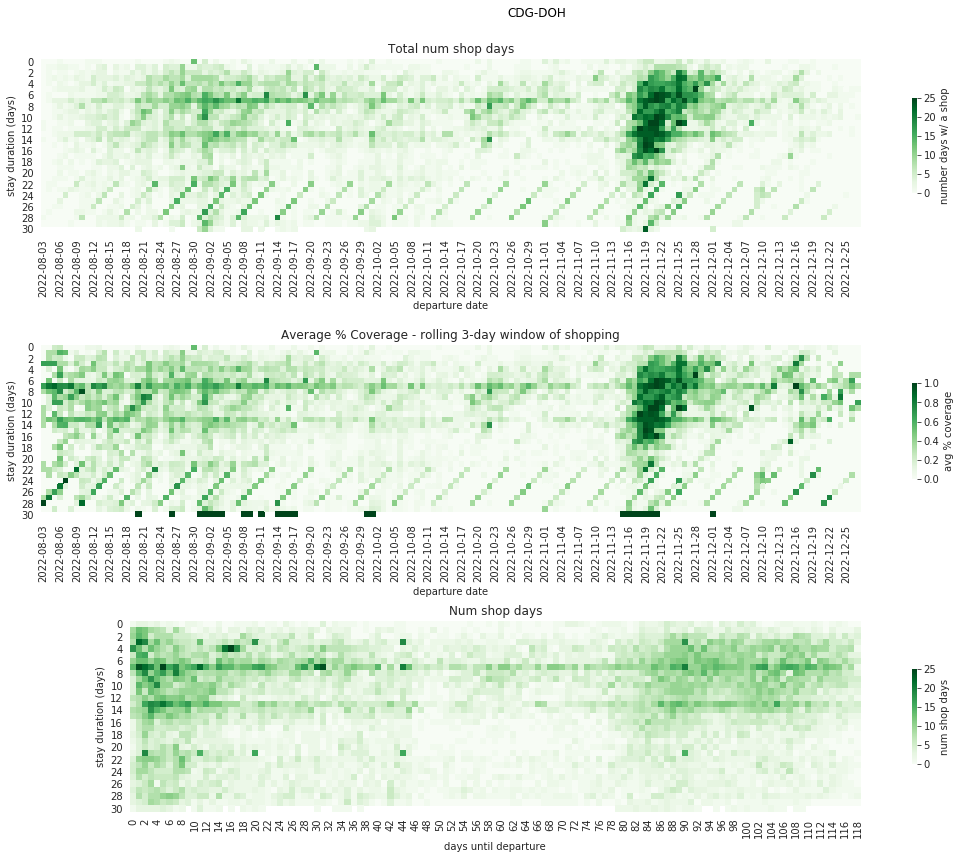

In [47]:
market = 'CDG-DOH'
shops_proc_df = process_base(market, cnt_df, date_df_missing_removed)
shops_pdf = window_calcs_shops(market, shops_proc_df)
plot_shops(market, shops_pdf, "shops", True)

In [ ]:
gaps_proc_df = process_base(market, cnt_df, date_cross_df)
gaps_pdf = window_calcs_gaps(market, gaps_proc

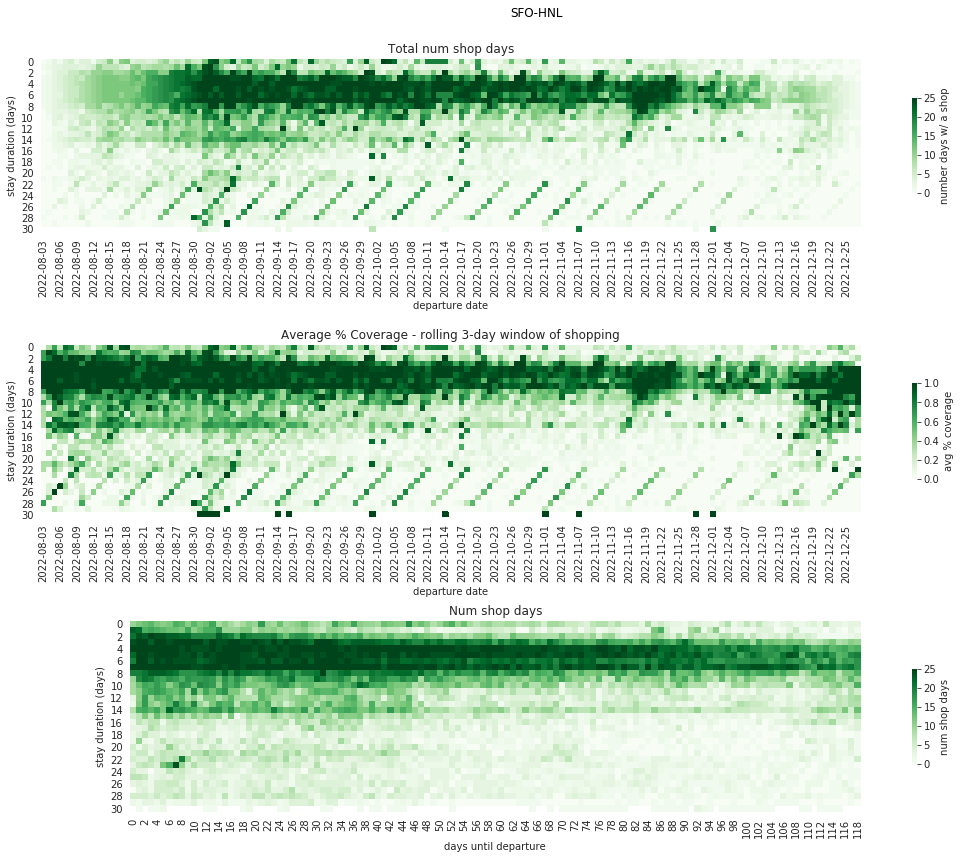

In [48]:
market = 'SFO-HNL'
shops_proc_df = process_base(market, cnt_df, date_df_missing_removed)
shops_pdf = window_calcs_shops(market, shops_proc_df)
plot_shops(market, shops_pdf, "shops", True)

In [ ]:
gaps_proc_df = process_base(market, cnt_df, date_cross_df)
gaps_pdf = window_calcs_gaps(market, gaps_proc

In [ ]:
market_list